## GoodsForecast Hack хакатон

## Команда: микромолекула1100

## Направление: !!!

в своем решении мы не использовали колонку датасета 'Probability'

**Участники команды:** Садчиков Андрей, Якубов Камиль, Карпов Степан, Никитин Артемий


Данный ноутбук полностью *интерактивный* - запустив клетки ноутбука последовательно, Вы получите на выходе тот же самый файл, который мы отослали в Google-форму (с точностью до рандома перестановки выборки, на которой обучалась модель)

*Краткое описание решение:* сохранив данные, мы провели их анализ, исключили мусорные столбцы, проверили корреляцию между различными признаками, провели анализ созданных нами новых фич, а затем на очищенных данных обучили модель с помощью библиотеки CatBoost

Данный ноутбук содержит краткое описание работы, которую выполнила команда во время хакатона. Он разделен на 3 логические части:

*  Загрузка данных с сервера
*  Обработка данных, создание новых фич
*  Обучение модели на полученных данных





## Загрузка данных

In [1]:
!pip install pyodbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.8/334.8 kB 6.3 MB/s eta 0:00:00


In [2]:
import pyodbc
import pandas as pd
import numpy as np


class Installer:
    def __init__(self):
        self.__install_dependencies()

    def load_train_test(self):
        conn_str = """
            Driver={ODBC Driver 17 for SQL Server};
            Server=109.71.11.235;
            Database=GFC.Hackathon;
            UID=participant;
            PWD=AiNRYmEatiBL;
        """

        conn = pyodbc.connect(conn_str)
        train_query = "select * from dbo.Features f where f.IsCorrect is not null"
        train_df = pd.read_sql(train_query, conn)

        test_query = "select * from dbo.Features f where f.IsCorrect is null"
        test_df = pd.read_sql(test_query, conn)
        return train_df, test_df


    def __install_dependencies(self):
        sh = """
        if ! [[ "16.04 18.04 20.04 22.04" == *"$(lsb_release -rs)"* ]];
        then
            echo "Ubuntu $(lsb_release -rs) is not currently supported.";
            exit;
        fi

        curl https://packages.microsoft.com/keys/microsoft.asc | sudo tee /etc/apt/trusted.gpg.d/microsoft.asc
        curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list | sudo tee /etc/apt/sources.list.d/mssql-release.list

        sudo apt-get update
        sudo ACCEPT_EULA=Y apt-get install -y msodbcsql17
# optional: for bcp and sqlcmd
        sudo ACCEPT_EULA=Y apt-get install -y mssql-tools
        echo 'export PATH="$PATH:/opt/mssql-tools/bin"' >> ~/.bashrc
        source ~/.bashrc
# optional: for unixODBC development headers
        sudo apt-get install -y unixodbc-dev
        """
        with open('script.sh', 'w') as file:
          file.write(sh)

        !bash script.sh

In [3]:
installer = Installer()
train_data, test_data = installer.load_train_test()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0  13742      0 --:--:-- --:--:-- --:--:-- 13845
-----BEGIN PGP PUBLIC KEY BLOCK-----
Version: GnuPG v1.4.7 (GNU/Linux)

mQENBFYxWIwBCADAKoZhZlJxGNGWzqV+1OG1xiQeoowKhssGAKvd+buXCGISZJwT
LXZqIcIiLP7pqdcZWtE9bSc7yBY2MalDp9Liu0KekywQ6VVX1T72NPf5Ev6x6DLV
7aVWsCzUAF+eb7DC9fPuFLEdxmOEYoPjzrQ7cCnSV4JQxAqhU4T6OjbvRazGl3ag
OeizPXmRljMtUUttHQZnRhtlzkmwIrUivbfFPD+fEoHJ1+uIdfOzZX8/oKHKLe2j
H632kvsNzJFlROVvGLYAk2WRcLu+RjjggixhwiB+Mu/A8Tf4V6b+YppS44q8EvVr
M+QvY7LNSOffSO6Slsy9oisGTdfE39nC7pVRABEBAAG0N01pY3Jvc29mdCAoUmVs
ZWFzZSBzaWduaW5nKSA8Z3Bnc2VjdXJpdHlAbWljcm9zb2Z0LmNvbT6JATUEEwEC
AB8FAlYxWIwCGwMGCwkIBwMCBBUCCAMDFgIBAh4BAheAAAoJEOs+lK2+EinPGpsH
/32vKy29Hg51H9dfFJMx0/a/F+5vKeCeVqimvyTM04C+XENNuSbYZ3eRPHGHFLqe
MNGxsfb7C7ZxEeW7J/vSzRgHxm7ZvESisUYRFq2sgkJ+HFERNrqfci45bdhmrUsy
7SWw9ybxdFOkuQoyKD3tBmiGfONQMlBaOMWdAsic9

<ipython-input-2-1d1194a752a2>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train_df = pd.read_sql(train_query, conn)
<ipython-input-2-1d1194a752a2>:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_df = pd.read_sql(test_query, conn)


Мы загрузили тренировочные данные: *train_data* и тестовые данные: *test_data*. На протяжении всего ноутбука мы будем хранить эти датафреймы, изменяя их одинаково и не меняя порядок во втором датафрейме. Затем, очистив данные, мы просто обучимся на них, и применим к датафрейму *test_data*

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
df = pd.DataFrame(train_data)
false_samples = df[df['IsCorrect'] == False]
true_samples = df[df['IsCorrect'] == True]

num_true_samples = len(true_samples) * 3 // 2
false_samples = false_samples.sample(n=num_true_samples, random_state=42)

train_data = pd.concat([false_samples, true_samples], ignore_index=True)

In [6]:
# сохраним колонки, требующиеся в файле ответов
location_id = test_data['LocationId']
product_id = test_data['ProductId']
validation_dataframe = test_data['ValidationDateTime']
answers = test_data['IsCorrect']

Посмотрим на импортированные датафреймы

In [7]:
test_data

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288606,2023-07-25 14:57:04,0.406708,None,14.0,13.0,0.071429,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
1,63,288606,2023-08-03 14:58:53,0.460643,None,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
2,63,288783,2023-07-24 14:57:11,0.404959,None,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
3,63,288783,2023-08-03 14:57:39,0.659497,None,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
4,63,289136,2023-07-24 14:57:09,0.299769,None,6.0,6.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2950,572875,2023-07-26 15:01:26,0.248685,None,19.0,18.0,0.052632,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40767,2950,574768,2023-07-31 15:07:00,0.173554,None,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40768,2950,576631,2023-07-26 15:01:27,0.930926,None,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
40769,2950,576631,2023-07-28 15:04:19,0.704421,None,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


In [8]:
train_data

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,84,444341,2023-07-05 15:09:48.000,0.204082,False,8.0,8.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,1477,440169,2023-06-27 15:34:20.880,0.996424,False,3.0,2.0,0.333333,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,263,485346,2023-07-07 14:58:41.000,0.475120,False,14.0,13.0,0.071429,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,961,428334,2023-06-09 14:57:34.000,0.714232,False,0.0,0.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,2720,463471,2023-06-26 15:00:30.000,0.967210,False,1.0,1.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77970,2950,563946,2023-07-19 15:01:09.000,0.869408,True,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
77971,2950,574754,2023-07-13 15:08:52.000,0.316987,True,22.0,21.0,0.045455,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
77972,2950,574768,2023-07-19 15:01:04.000,0.656481,True,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
77973,2950,576631,2023-07-12 15:17:30.000,0.542776,True,1.0,0.0,1.000000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


In [9]:
train_data = train_data.sample(frac=1, random_state=42)

Для увеличения эффективности модели сразу заменим все False на 0, а все True на 1, поскольку значения True и False содержатся только в столбцах, состоящих из этих значений, что не приведет к путанице

In [10]:
train_data.replace({False: 0, True: 1}, inplace=True)
test_data.replace({False: 0, True: 1}, inplace=True)

Заметим, что колонку ValidationDateTime лучше разбить на несколько временных категорий, поскольку это может потенциально принести новую информацию

In [12]:
fields = ['Day', 'Hour', 'Week']
f = lambda x: pd.Series([x.day, x.hour,
                         x.isocalendar()[1]],
                         index=fields)
train_data[fields] = train_data["ValidationDateTime"].apply(f)
train_data.drop("ValidationDateTime", axis=1, inplace=True)
test_data[fields] = test_data["ValidationDateTime"].apply(f)
test_data.drop("ValidationDateTime", axis=1, inplace=True)

In [13]:
columns_to_drop = ['Column6', 'Column7', 'Column18']
train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)

Посмотрим, колонки какого типа встречаются у нас в датасете

In [14]:
group_by_type = dict(train_data.columns.to_series().groupby(train_data.dtypes).groups)
group_by_type = {str(k): v for k, v in group_by_type.items()}
group_by_type

{'int64': Index(['LocationId', 'ProductId', 'IsCorrect', 'Column12', 'Column19',
        'Column24', 'Column25', 'Day', 'Hour', 'Week'],
       dtype='object'),
 'float64': Index(['Probability', 'Column8', 'Column11', 'Column13', 'Column14',
        'Column15', 'Column16', 'Column17', 'Column20', 'Column21', 'Column22',
        'Column23', 'Column27', 'Column28', 'Column29', 'Column30', 'Column31',
        'Column32', 'Column33', 'Column34', 'Column35', 'Column36', 'Column37',
        'Column38', 'Column39', 'Column40', 'Column41', 'Column42', 'Column43',
        'Column44', 'Column45', 'Column46', 'Column47', 'Column49', 'Column50',
        'Column51', 'Column52', 'Column53', 'Column54', 'Column55', 'Column56',
        'Column57', 'Column58', 'Column59', 'Column60', 'Column61', 'Column62',
        'Column63', 'Column64', 'Column65', 'Column67'],
       dtype='object'),
 'object': Index(['Column9', 'Column10', 'Column26', 'Column66'], dtype='object')}

Посмотрим, сколько NaN'ов содержится в колонках типа 'object'

In [15]:
train_data[group_by_type["object"]].isna().sum()

Column9     77975
Column10    77975
Column26    77975
Column66    77975
dtype: int64

Для большей визуализации построим гистограммы

In [16]:
import matplotlib.pyplot as plt
import math

def plot_features(features, figsize):
  fig, axs = plt.subplots(math.ceil(len(features) / 5), 5, figsize=figsize)
  axs = axs.flatten()
  fig.tight_layout(pad=2.0)

  for i, feature_name in enumerate(features):
    axs[i].hist(train_data[feature_name], bins=30, color='blue', alpha=0.7)
    axs[i].set_title(feature_name)
  plt.show()

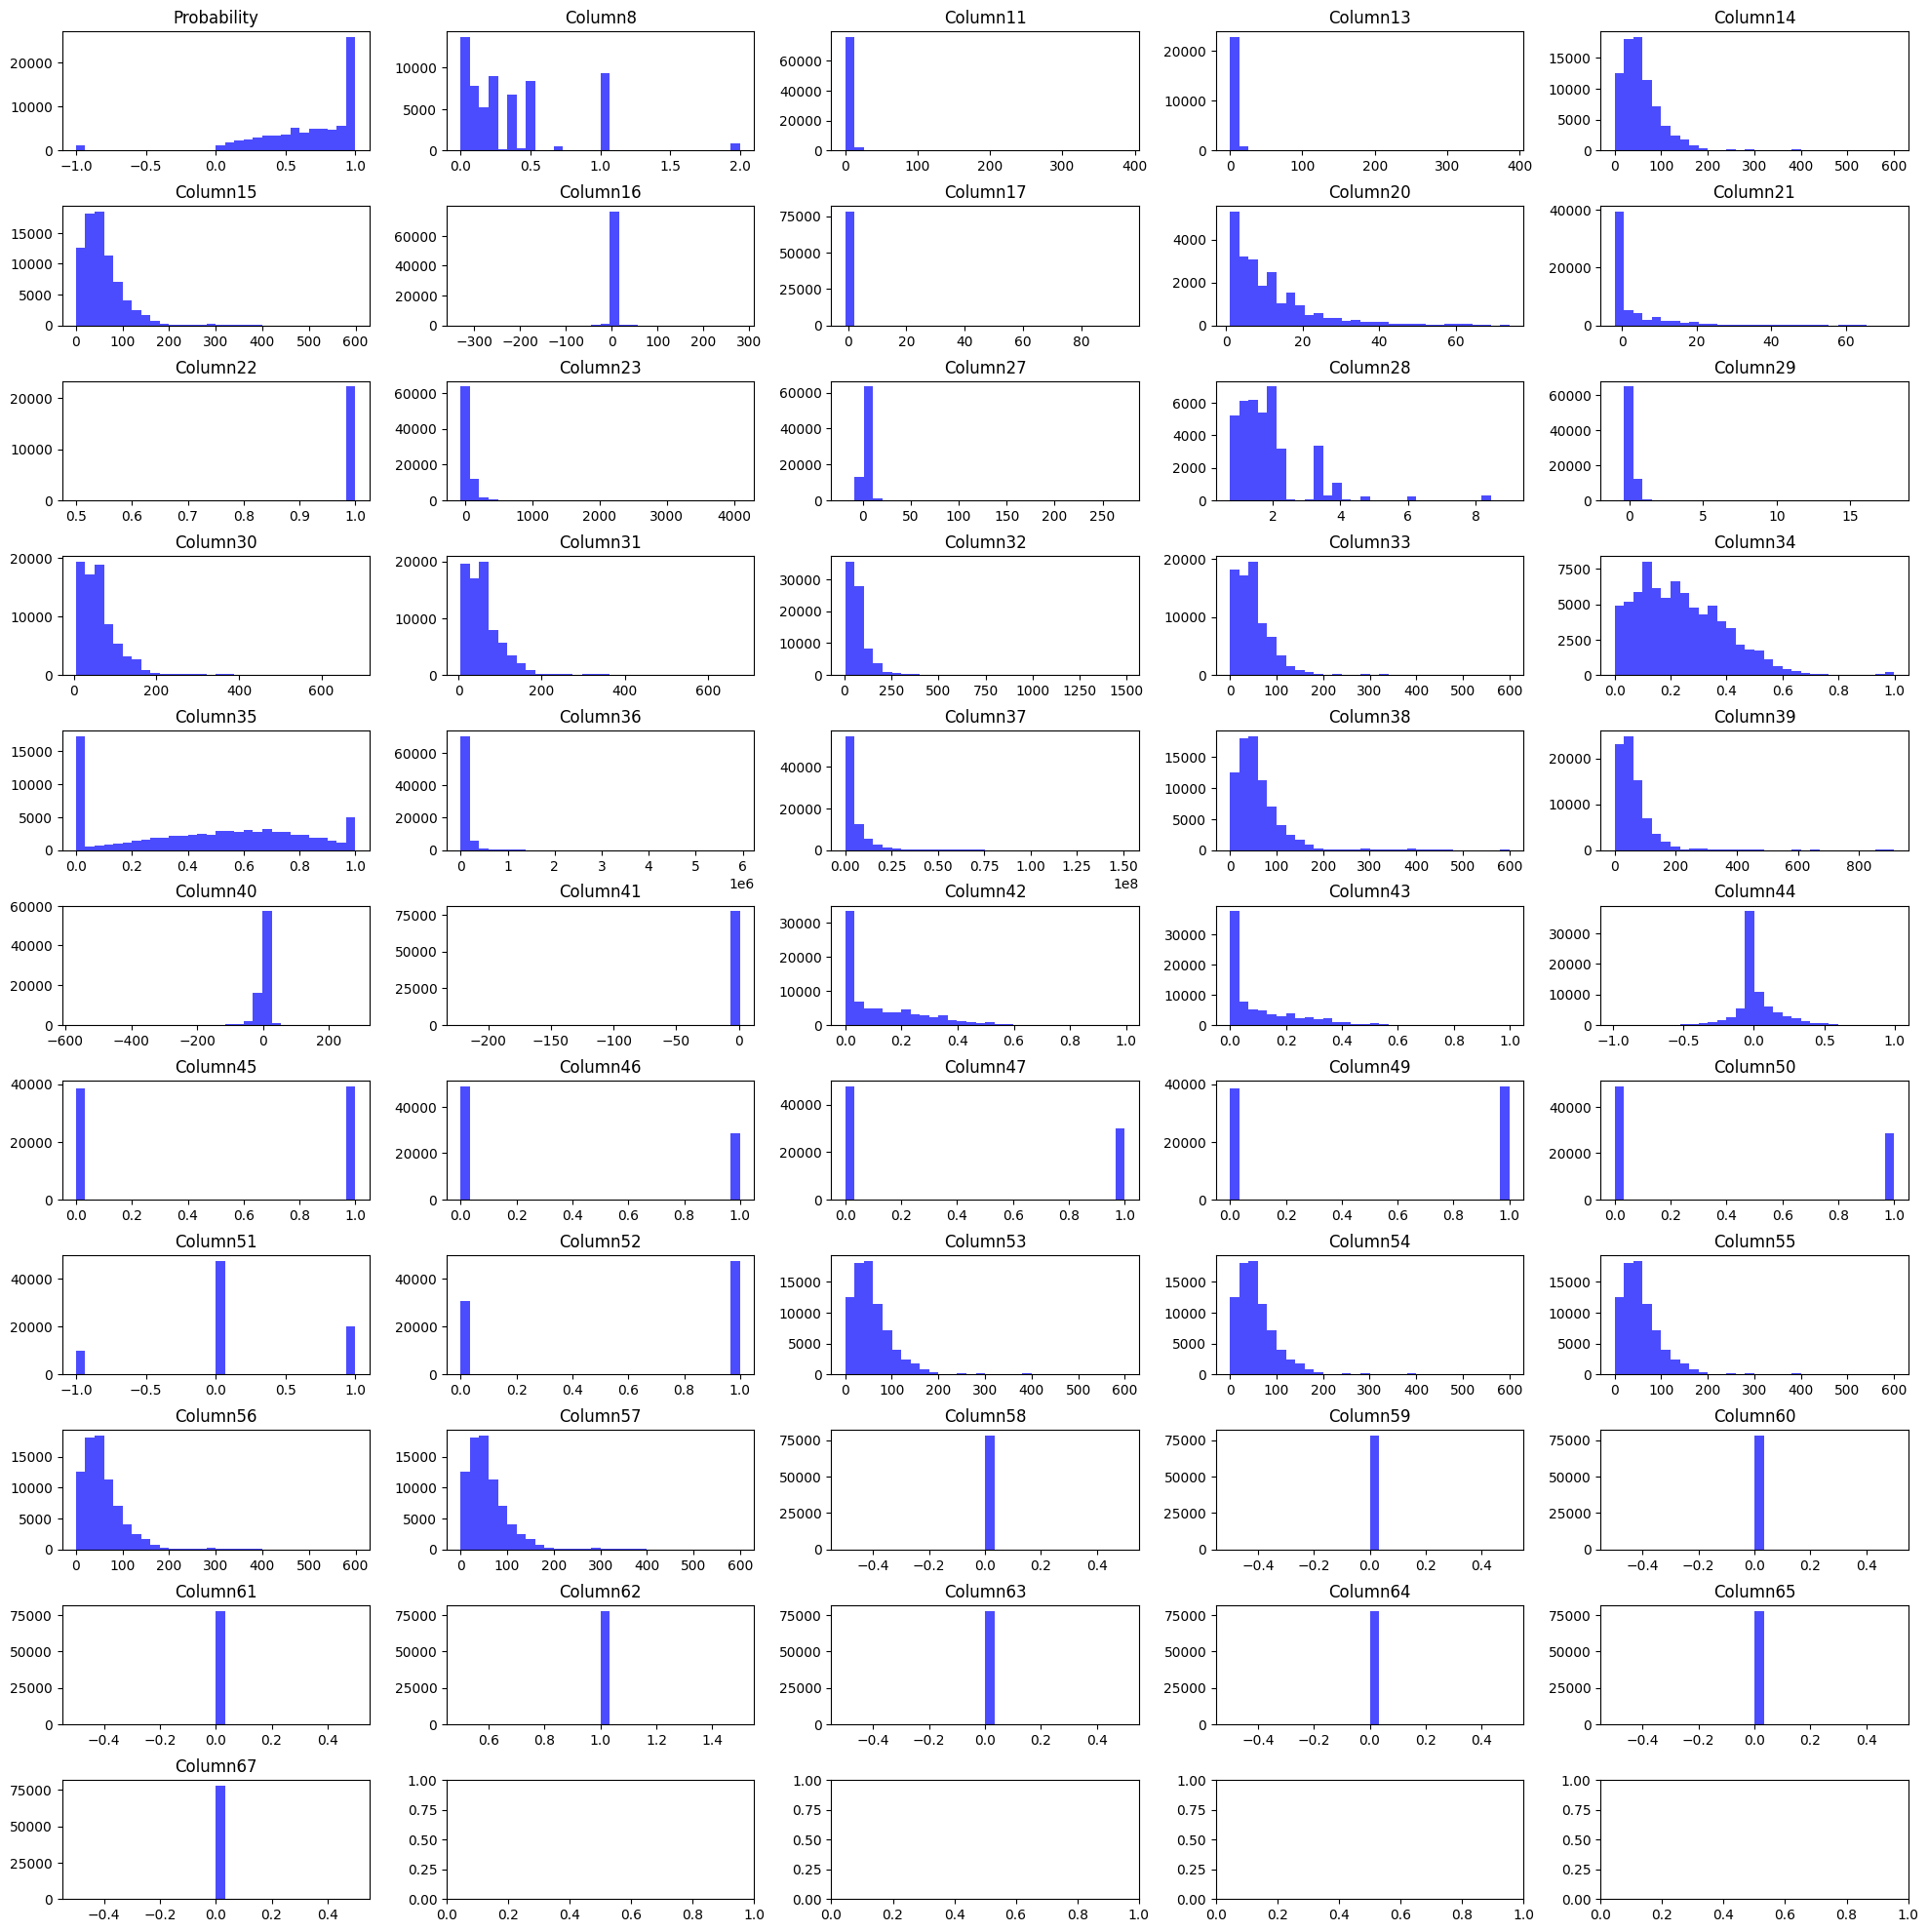

In [17]:
plot_features(group_by_type['float64'], (20, 20))

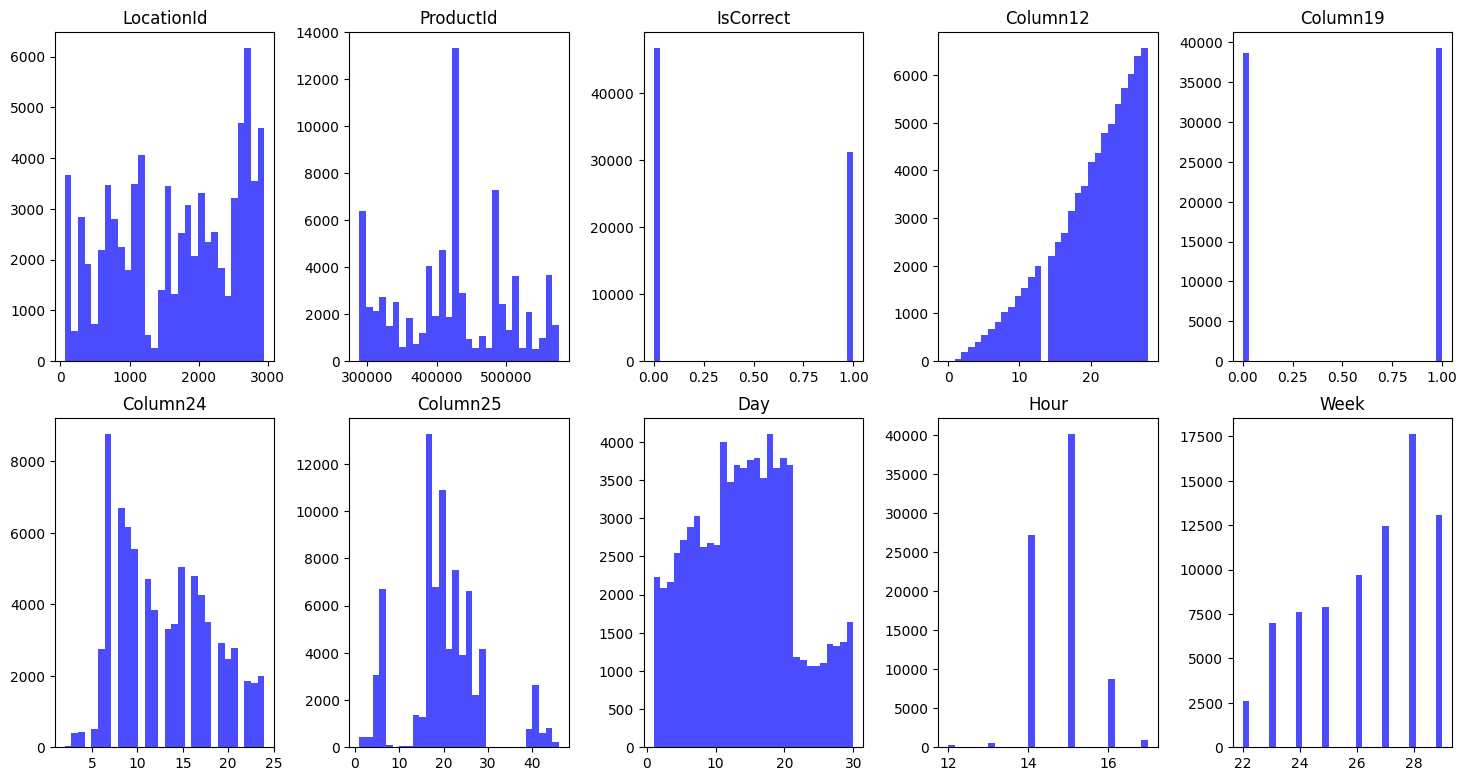

In [18]:
plot_features(group_by_type['int64'], (15, 8))

Выделим "подозрительные" колонки - то есть те колонки, которые содержат всего одно значение или ДОПИСАТЬ

In [19]:
trash_cols = []
for col in train_data.columns:
    uni = train_data[col].unique()
    if len(uni) == 1 or (len(uni) == 2 and train_data[col].isna().any()):
        trash_cols.append(col)
np.array(trash_cols)

array(['Column9', 'Column10', 'Column26', 'Column58', 'Column59',
       'Column60', 'Column61', 'Column62', 'Column63', 'Column64',
       'Column65', 'Column66', 'Column67'], dtype='<U8')

Удалим эти колонки, поскольку они не несут никакой информации

In [20]:
train_data.drop(columns=trash_cols, inplace=True)
test_data.drop(columns=trash_cols, inplace=True)

При ручном анализе нетрудно заметить, что существует много колонок, которые подозрительно похожи друг на друга. Выделим такие колонки с помощью следущей ячейки

In [21]:
similar = []
thresh = 0.0
for i, col1 in enumerate(train_data.columns):
    for col2 in train_data.columns[i + 1:]:
        try:
            corr = np.log(train_data[col1]).corr(np.log(train_data[col2]))
            if corr >= 1 - thresh:
                similar.append((corr, col1, col2))
        except:
            pass

cols_classes = []
for corr, col1, col2 in similar:
    if len(cols_classes) == 0:
        cols_classes.append({col1, col2})
        continue
    new_cls = True
    for cls in cols_classes:
        if col1 in cls or col2 in cls:
            cls |= {col1, col2}
            new_cls = False
    if new_cls:
        cols_classes.append({col1, col2})

for i in range(len(cols_classes)):
    cols_classes[i] = sorted(list(cols_classes[i]))
np.array(cols_classes)

array([['Column14', 'Column38', 'Column53', 'Column54', 'Column55',
        'Column56', 'Column57']], dtype='<U8')

При проверке оказывается, что выделенные столбцы вовсе являются дубликатами друг друга. Удалим их

In [22]:
to_drop = []
for group in cols_classes:
    to_drop += group[1:]
train_data.drop(columns=to_drop, inplace=True)
test_data.drop(columns=to_drop, inplace=True)

In [23]:
for col in train_data.columns:
    if train_data[col].isna().sum() < train_data.shape[0] / 100:
        train_data.dropna(subset=[col], inplace=True)

In [24]:
barren_cols = []
for col in train_data.columns:
    if train_data[col].isna().sum() >= train_data.shape[0] / 100:
        barren_cols.append(col)
barren_cols

['Column8', 'Column13', 'Column20', 'Column21', 'Column22', 'Column28']

In [25]:
for col in barren_cols:
    train_data[col].fillna(train_data[col].dropna().mean(), inplace=True)

In [26]:
barren_cols = []
for col in test_data.columns:
    if test_data[col].isna().sum() >= train_data.shape[0] / 100:
        barren_cols.append(col)
np.array(barren_cols)

array(['IsCorrect', 'Column8', 'Column13', 'Column20', 'Column21',
       'Column22', 'Column28'], dtype='<U9')

In [27]:
for col in barren_cols:
    test_data[col].fillna(test_data[col].dropna().mean(), inplace=True)

In [28]:
for col in train_data.columns:
    if np.array_equal(train_data[col], train_data[col].astype(int)):
        train_data[col] = train_data[col].astype(np.int64)

for col in test_data.columns:
    if (col == 'IsCorrect'):
      continue
    try:
      if np.array_equal(test_data[col], test_data[col].astype(int)):
          test_data[col] = test_data[col].astype(np.int64)
    except:
      pass

In [29]:
uniq_cnt = []
num_features = []
bin_features = []
for col in train_data.columns:
    uniq_cnt.append((train_data[col].unique().shape[0], col))
    is_int = train_data[col].apply(lambda x: x == int(x))
    if (train_data[col].unique().shape[0] == 2):
        bin_features.append(col)
    elif (train_data[col].unique().shape[0] > 5000 or not is_int.all()):
        num_features.append(col)
uniq_cnt.sort()

cat_features = np.setdiff1d(train_data.columns, num_features + bin_features)

print(f'num_features = {num_features}')
print(f'bin_features = {bin_features}')
print(f'cat_features = {cat_features}')

num_features = ['Probability', 'Column8', 'Column11', 'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column20', 'Column21', 'Column22', 'Column23', 'Column27', 'Column28', 'Column29', 'Column30', 'Column31', 'Column32', 'Column33', 'Column34', 'Column35', 'Column36', 'Column37', 'Column39', 'Column40', 'Column41', 'Column42', 'Column43', 'Column44']
bin_features = ['IsCorrect', 'Column19', 'Column45', 'Column46', 'Column47', 'Column49', 'Column50', 'Column52']
cat_features = ['Column12' 'Column24' 'Column25' 'Column51' 'Day' 'Hour' 'LocationId'
 'ProductId' 'Week']


Посмотрим, какой результат дает очищенный датасет при обучении на модели градиентного бустинга, реализованной в библиотеке catboost

In [30]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.1 MB/s eta 0:00:00


In [31]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTENC

Посмотрим, какую метрику можно получить с уже полученными данными

In [33]:
cat_cols = ['Day', 'Hour', 'LocationId', 'ProductId', 'Week'] + bin_features
cat_cols.remove('IsCorrect')

def SplitDataset(train_data):
  return train_data.drop(columns=['IsCorrect']), train_data['IsCorrect']

best_model = CatBoostClassifier(iterations=60, depth=6, learning_rate=0.13, eval_metric='AUC', cat_features=cat_cols, verbose=0)
X_train, y_train = SplitDataset(train_data[:50000])
X_test, y_test = SplitDataset(train_data[50000:])

X_train[cat_cols] = X_train[cat_cols].fillna('NaN').astype(str)
X_test[cat_cols] = X_test[cat_cols].fillna('NaN').astype(str)

best_model.fit(X_train, y_train)

final_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(pd.DataFrame(y_test).values, pd.DataFrame(final_pred).values)

0.8914236360860444

Получили метрику, соответствующую ожиданиям! В дальнейшем переберем гиперпараметры, а пока продолжим анализ данных

In [34]:
import seaborn as sns
from scipy.stats import skew, boxcox

def plot_hist(df, title=''):
    num_cols = 4
    num_rows = math.ceil(len(df.columns) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.histplot(data=df[col], ax=axes[i])
        axes[i].set_title(f'{col}, skew {df[col].skew():.2f}')
    for j in range(len(df.columns), num_rows * num_cols):
        axes[j].axis('off')
    plt.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()

def plot_violin(df, title=''):
    num_cols = 6
    num_rows = math.ceil(len(df.columns) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.violinplot(y=df[col], ax=axes[i])
        axes[i].set_title(f'{col}, skew {skew(df[col]):.2f}')
    for j in range(len(df.columns), num_rows * num_cols):
        axes[j].axis('off')
    plt.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()


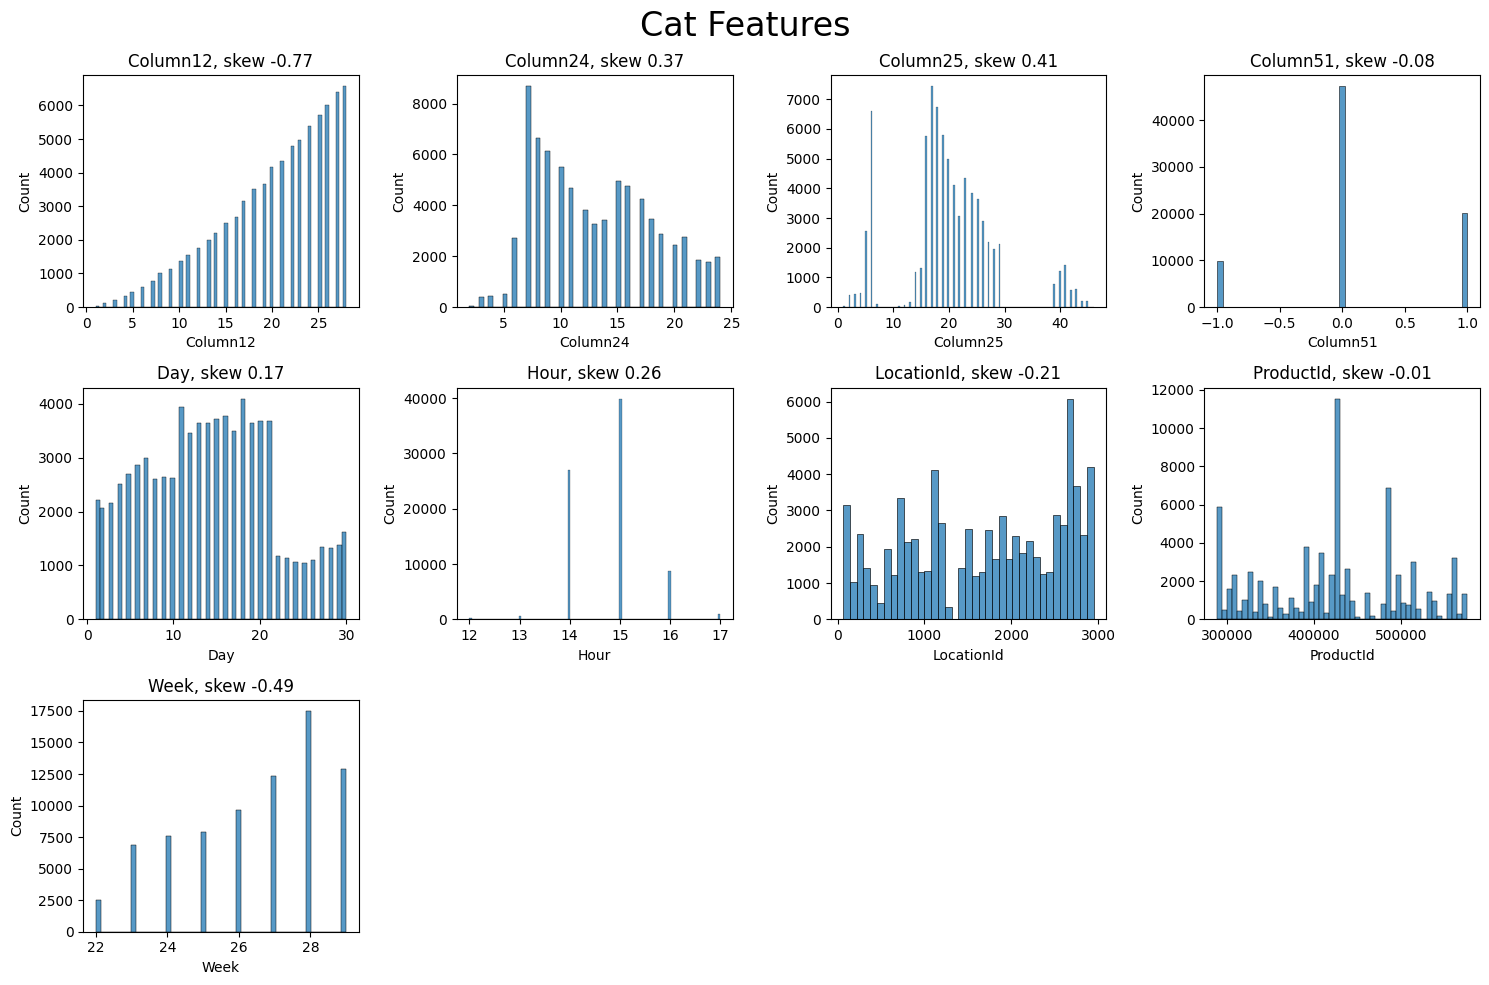

In [35]:
plot_hist(train_data[cat_features], "Cat Features")

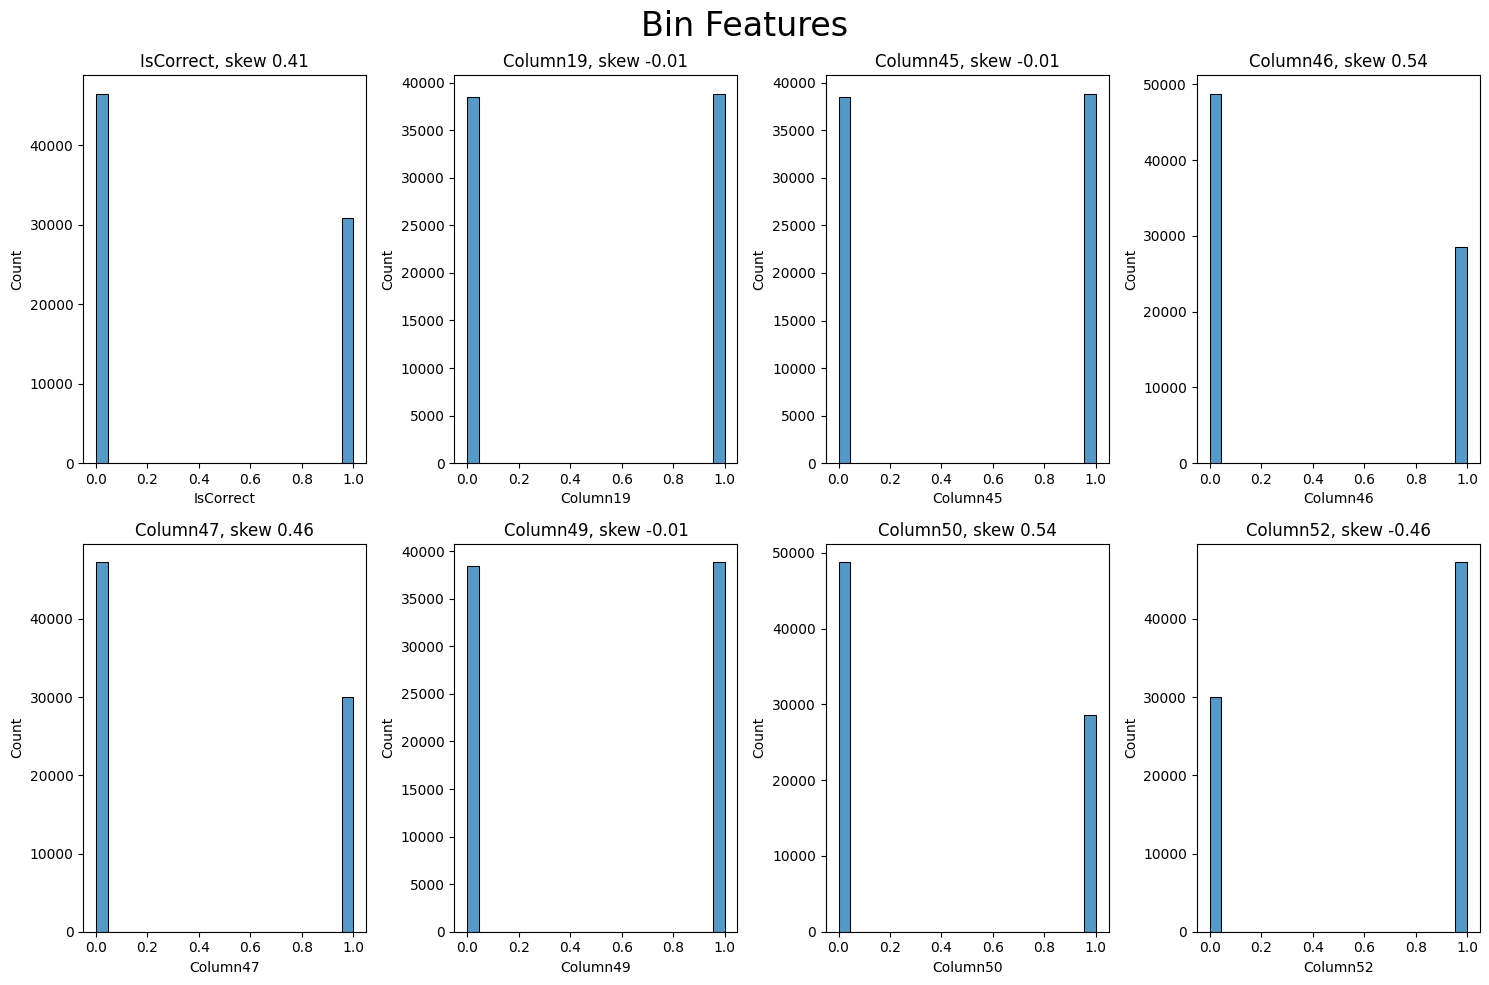

In [36]:
plot_hist(train_data[bin_features], "Bin Features")

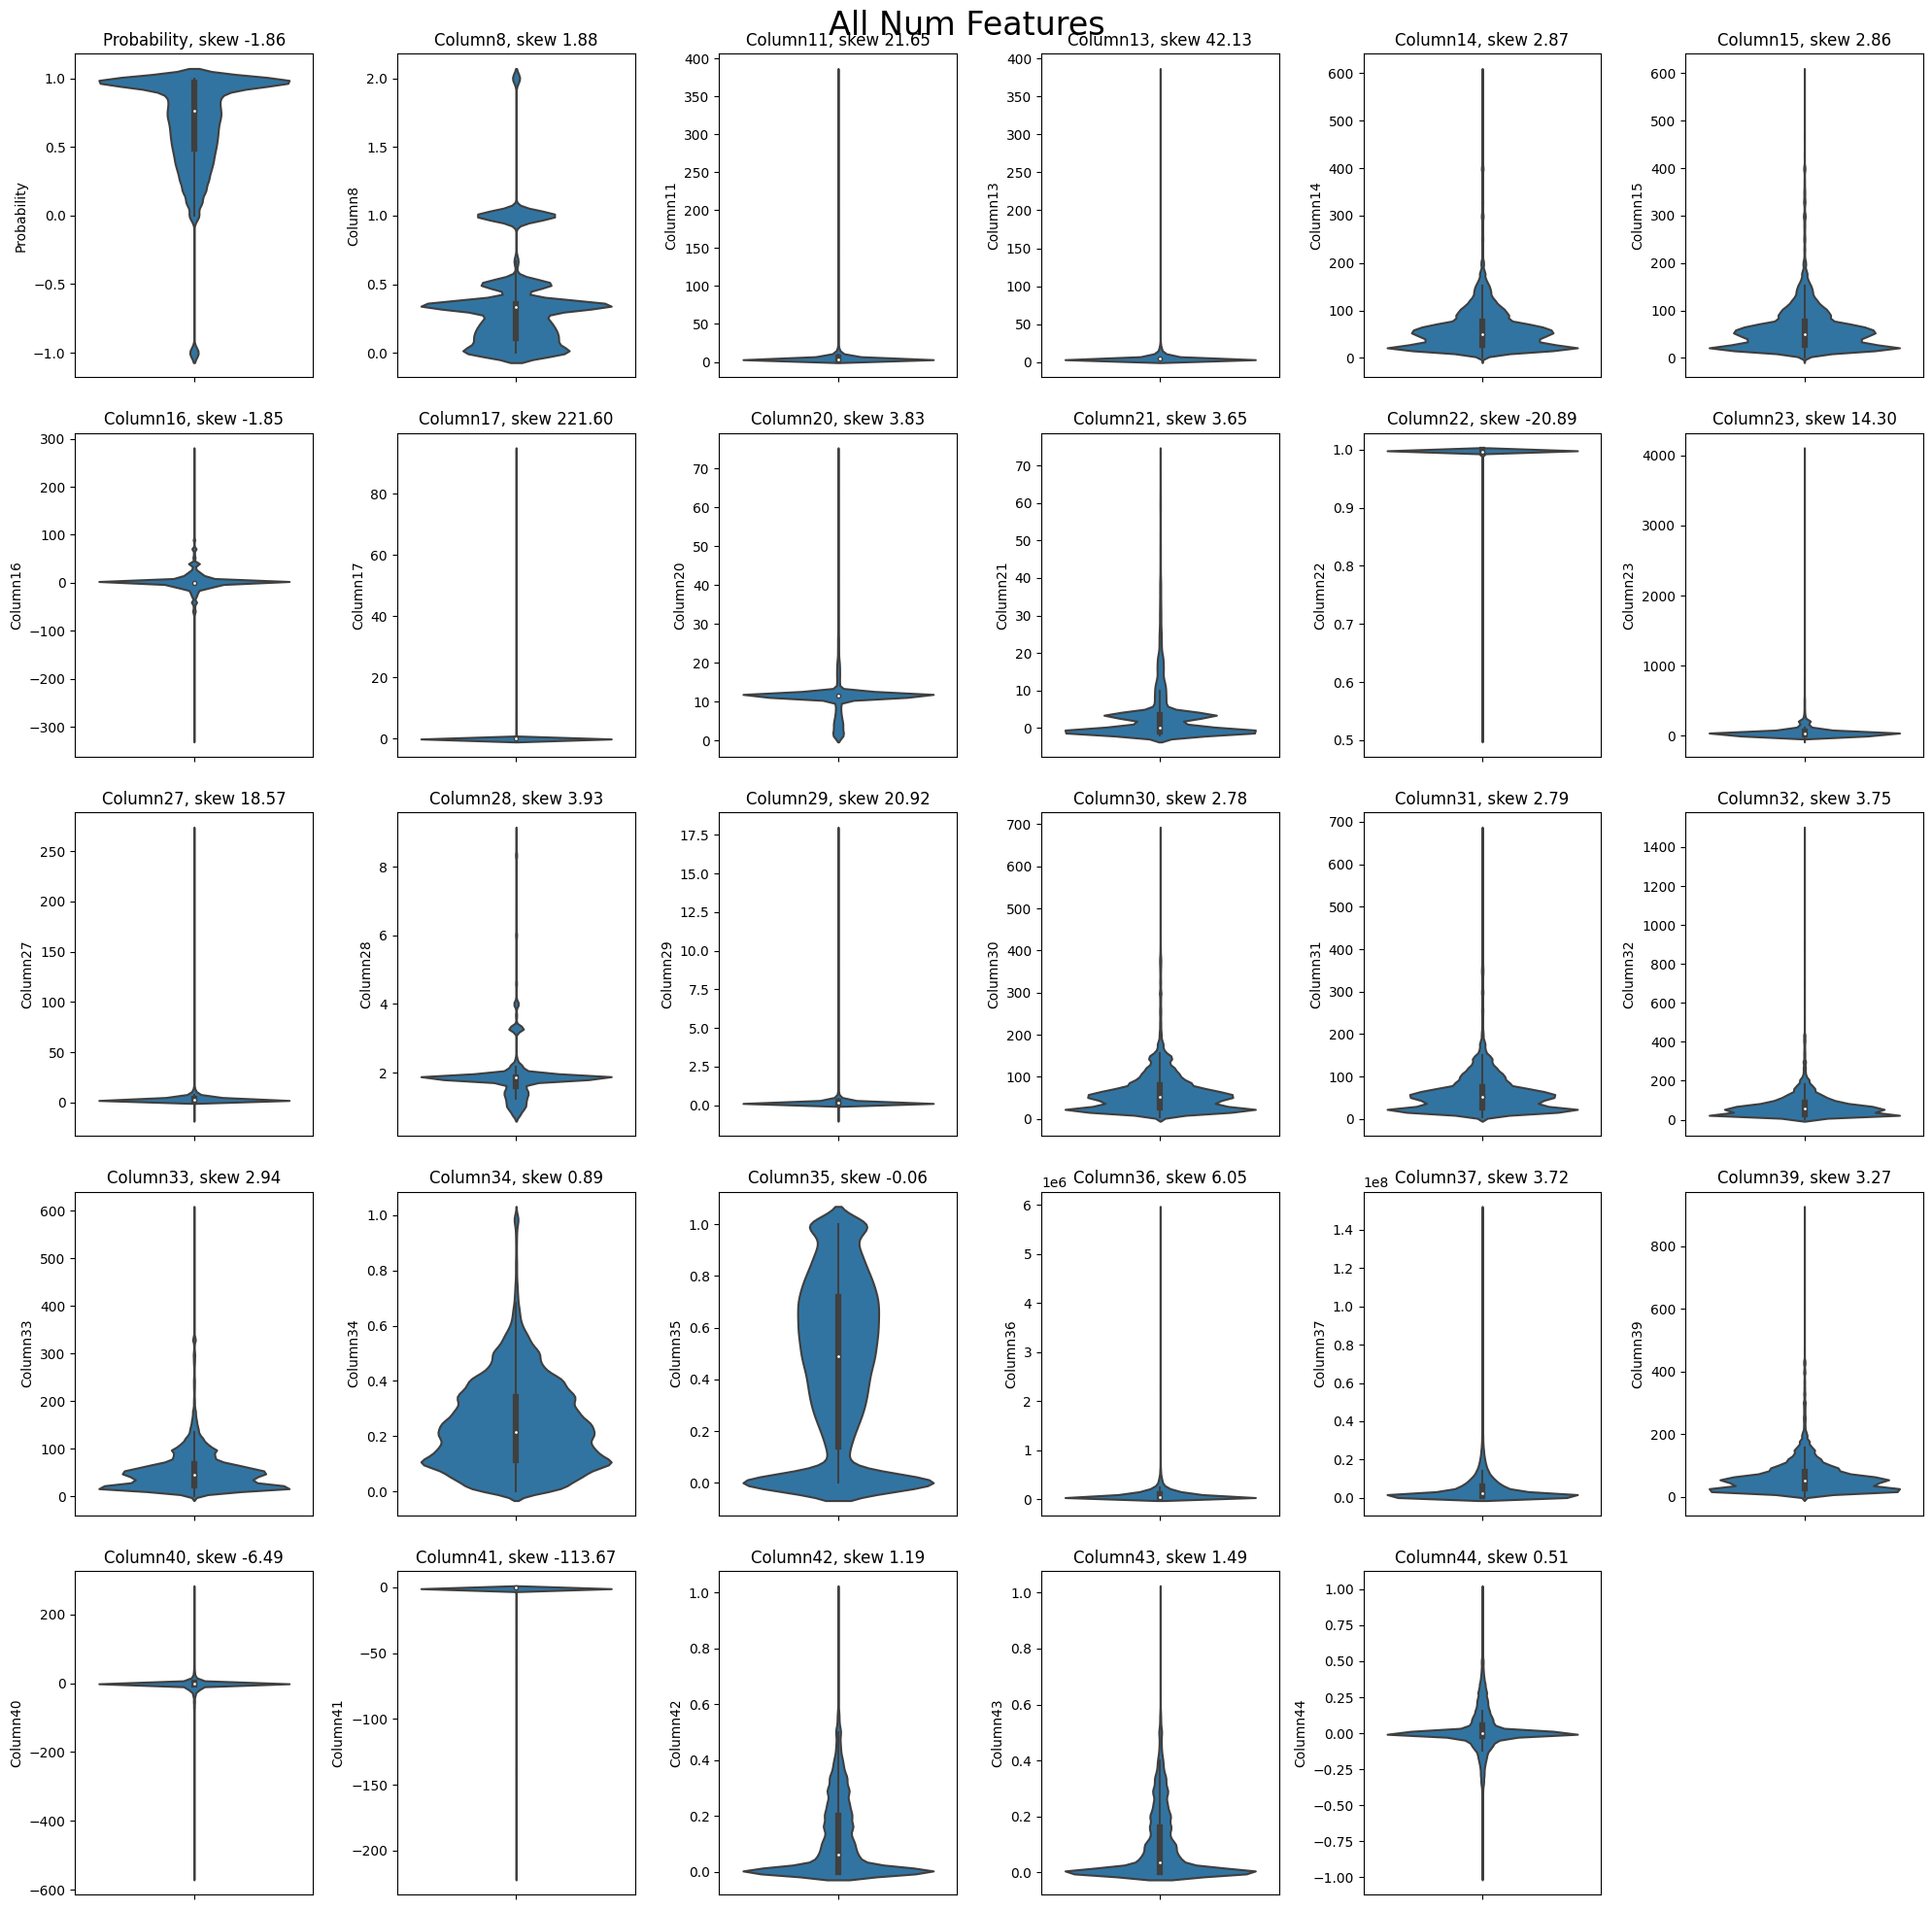

In [37]:
plot_violin(train_data[num_features], "All Num Features")

## Обучим модели на очищенных данных

In [38]:
train_data.drop("Probability", axis=1, inplace=True)
test_data.drop("Probability", axis=1, inplace=True)

In [39]:
train_data = train_data.sample(frac=1).reset_index(drop=True)

// перебор был запущен на другой машине, поэтому здесь нет вывода программы

Оптимальные параметры уже поставлены через несколько ячеек

In [ ]:
%%time

cat_cols = ['Day', 'Hour', 'LocationId', 'ProductId', 'Week'] + bin_features
cat_cols.remove('IsCorrect')

def SplitDataset(train_data):
  return train_data.drop(columns=['IsCorrect']), train_data['IsCorrect']

X, y = SplitDataset(train_data)
X[cat_cols] = X[cat_cols].fillna('NaN').astype(str)

param_grid = {
    'iterations': [50, 60, 70, 100, 250],
    'depth': [6, 7, 8],
    'learning_rate': [0.08, 0.1, 0.12, 0.13],
}

grid_search = GridSearchCV(CatBoostClassifier(eval_metric='AUC', cat_features=cat_cols, verbose=2),
                           param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

grid_search.fit(X, y)

In [ ]:
grid_search.best_params_

Проверим финальную метрику, чтобы понимать наши ожидания от модели

In [40]:
cat_cols = ['Day', 'Hour', 'LocationId', 'ProductId', 'Week'] + bin_features
cat_cols.remove('IsCorrect')

def SplitDataset(train_data):
  return train_data.drop(columns=['IsCorrect']), train_data['IsCorrect']

best_model = CatBoostClassifier(iterations=60, depth=6, learning_rate=0.13, eval_metric='AUC', cat_features=cat_cols, verbose=0)
X_train, y_train = SplitDataset(train_data[:50000])
X_test, y_test = SplitDataset(train_data[50000:])
X_train[cat_cols] = X_train[cat_cols].fillna('NaN').astype(str)
X_test[cat_cols] = X_test[cat_cols].fillna('NaN').astype(str)

best_model.fit(X_train, y_train)

final_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(pd.DataFrame(y_test).values, pd.DataFrame(final_pred).values)

0.893325513612849

Создадим модель с оптимальными гиперпараметрами и построим финальный ответ на основе её предсказаний

In [41]:
best_model = CatBoostClassifier(iterations=60, depth=6, learning_rate=0.13, eval_metric='AUC', cat_features=cat_cols, verbose=1)

X_train, y_train = SplitDataset(train_data)
X_test, y_test = SplitDataset(test_data)
X_train[cat_cols] = X_train[cat_cols].fillna('NaN').astype(str)
X_test[cat_cols] = X_test[cat_cols].fillna('NaN').astype(str)

best_model.fit(X_train, y_train)

final_pred = best_model.predict_proba(X_test)[:, 1]

df = pd.DataFrame({'LocationId': location_id,
                   'ProductId': product_id,
                   'ValidationDateTime': validation_dataframe,
                   'CalculatedProbability': final_pred})

df.to_csv("микромолекула1100_3.csv", index=False)

0:	total: 62.1ms	remaining: 3.66s
1:	total: 110ms	remaining: 3.18s
2:	total: 167ms	remaining: 3.17s
3:	total: 218ms	remaining: 3.06s
4:	total: 266ms	remaining: 2.93s
5:	total: 310ms	remaining: 2.79s
6:	total: 365ms	remaining: 2.76s
7:	total: 419ms	remaining: 2.72s
8:	total: 470ms	remaining: 2.66s
9:	total: 516ms	remaining: 2.58s
10:	total: 564ms	remaining: 2.51s
11:	total: 612ms	remaining: 2.45s
12:	total: 658ms	remaining: 2.38s
13:	total: 716ms	remaining: 2.35s
14:	total: 760ms	remaining: 2.28s
15:	total: 806ms	remaining: 2.21s
16:	total: 852ms	remaining: 2.15s
17:	total: 900ms	remaining: 2.1s
18:	total: 946ms	remaining: 2.04s
19:	total: 992ms	remaining: 1.98s
20:	total: 1.04s	remaining: 1.93s
21:	total: 1.08s	remaining: 1.87s
22:	total: 1.13s	remaining: 1.82s
23:	total: 1.18s	remaining: 1.77s
24:	total: 1.23s	remaining: 1.72s
25:	total: 1.27s	remaining: 1.67s
26:	total: 1.32s	remaining: 1.62s
27:	total: 1.37s	remaining: 1.57s
28:	total: 1.42s	remaining: 1.52s
29:	total: 1.48s	remaini

In [42]:
np.mean(final_pred)

0.19411696137003853